# Describe a pyramidal activity

**Highlights**:

**Observation**:

- Except for a very few neurons, waveform plots are currently too noisy to see spikes:
    - hypothesis: this could be due to the small sample size (13 spikes max for 4 secs)
        - action: we should increase the simulation duration

**Questions**: 

**Notes**:


## Setup

[TODO]
- pretty print the config with indents
- why are the waveforms incorrect?

In [7]:
# SETUP PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pprint as pp
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as spost
from probeinterface.plotting import plot_probe

pd.set_option('display.max_colwidth', None)

# SET PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
STUDY_FOLDER = '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_study'

os.chdir(PROJ_PATH)
from src.pipelines.simulation.dataeng.loading import load_params_for_one_simulation_piece
from src.pipelines.simulation.sorting import ground_truth
from src.pipelines.simulation.dataeng import loading_raw_recording
from src.pipelines.simulation.preprocessing import silico_preprocess
from src.nodes.simulation.dataeng.filtering import get_cell_spiking_above_thresh, get_cell_id_spiking_above_thresh
from src.nodes.utils import get_config
from src.nodes import viz
from src.nodes.simulation.dataeng.filtering import get_cell_spiking_above_thresh, create_study_object


# SETUP PARAMETERS
# the date of the simulation to run
SIMULATION_DATE = "2022_10_28"

# traces parameters
CHANNEL_ID = np.arange(64,80).tolist()   # plot traces from channels nearest to filtered neuron group
N_SAMPLE = 80000                         # plot x-max (number of samples)
MIN_MAX_AMPLITUDE = [-400, 150]          # plot y-max (voltage)

MIN_SPIKE = 10

# SETUP CONFIG
print("CONFIG:\n")
config = get_config(SIMULATION_DATE)
pp.pprint(config["dataset_conf"])
pp.pprint(config["param_conf"])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CONFIG:

{'input': {'one_piece': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/1f039ca3-7c27-4e0f-866e-e001f95620f4/0/BlueConfig',
           'simulated_traces_and_spikes': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128_0/results/',
           'simulation_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/spikeDetection/1f039ca3-7c27-4e0f-866e-e001f95620f4/0',
           'waveform_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_real_wfs',
           'weightspath': '/gpfs/bbp.cscs.ch/project/proj68/scratch/tharayil/coeffsreyespuerta.h5'},
 'output': {'ground_truth_sorting_object': {'write_path': '/gpfs/bbp.cscs.ch/project/proj68/scratch/imbeni/sorting/output/0_silico/Hex0_4s_reyes128/Hex0_4s_reyes128_true_spikes'},
            'out': '/gpfs/bbp.cscs.ch/project/proj68

In [8]:
# custom functions
def get_pyramidal(cell_properties):
    
    pyramidal_gids = cell_properties[cell_properties["morph_class"] == "PYR"].index
    return pyramidal_gids

def get_most_active_pyramidal(GroundTruthSpike, pyramidal_gids:np.array):

    id_spike_dict = GroundTruthSpike.get_total_num_spikes()
    pyramidal_id_spike_dict = {key: id_spike_dict[key] for key in pyramidal_gids}
    most_active_pyramidal_id = max(pyramidal_id_spike_dict, key=pyramidal_id_spike_dict.get)
    return most_active_pyramidal_id

def get_unit_waveform(trace, spike_time, sampling_freq=20000, ms_before=2, ms_after=2):
    n_sample_before = ms_before * sampling_freq / 1000
    n_sample_after = ms_after * sampling_freq / 1000
    waveform = []
    for spike in spike_time:
        this_waveform = trace[int(spike - n_sample_before) : int(spike + n_sample_after)]
        waveform.append(this_waveform)
    return np.array(waveform).T

def plot_unit_and_probe_location(
    cell_gid:int, circuit, raw_traces, preprocessed_traces, groundtruthspike, waveform_path:str, n_sample:int=80000, channel_id:list=[80, 55, 56, 57, 95], min_max_amplitude:list=[-150, 150]
    ):

    # inspect the probe's contact channels' locations
    probe = raw_traces.get_probe()

    # setup plot
    fig = plt.figure(figsize=(10,30));

    # setup layout
    spec = fig.add_gridspec(len(CHANNEL_ID), 2);

    # plot the unit's location with respect to the probe
    ax = fig.add_subplot(spec[:, 0]);
    plot_probe(probe.to_2d(axes='xy'), ax=ax, with_channel_index=True);

    # get unit true location
    unit_true_loc = circuit.cells.get(cell_gid, properties=["x","y","z"])

    # plot the unit's estimated location from the "center of mass" method
    ax.plot(unit_true_loc.x, unit_true_loc.y, "r+", markersize=20);

    # localize the most active unit
    # create waveform extractor to localize unit 
    WaveformExtractor = si.extract_waveforms(
        preprocessed_traces, 
        groundtruthspike, 
        waveform_path,
        load_if_exists=True, 
        overwrite=False,
        ms_before=2, 
        ms_after=2., 
        max_spikes_per_unit=None
        )
    cell_loc = spost.compute_unit_locations(WaveformExtractor, method="center_of_mass", outputs="by_unit")
    cell_estimated_loc = cell_loc[cell_gid]


    # plot the unit's estimated location
    ax.plot(cell_estimated_loc[0], cell_estimated_loc[1], "r.", markersize=20);

    # report
    print("neuron's true location (red dot) and estimated location (red cross)")

    # get most active unit's spike train
    most_active_unit_spikes = groundtruthspike.get_unit_spike_train(unit_id = cell_gid)
    most_active_unit_spikes = most_active_unit_spikes[most_active_unit_spikes<N_SAMPLE]

    # plot unit spikes against nearby channels' traces
    for ix in range(len(CHANNEL_ID)):
        
        # setup axis
        ax = fig.add_subplot(spec[ix, 1]);
        
        # plot preprocessed trace
        trace = preprocessed_traces.get_traces()[:N_SAMPLE, CHANNEL_ID[ix]]

        # legend
        ax.plot(trace);
        ax.eventplot(most_active_unit_spikes, linelengths = 20, lineoffsets=MIN_MAX_AMPLITUDE[1]*0.9, colors="r");    
        ax.set_title(f"channel id {CHANNEL_ID[ix]}")
        ax.set_ylim(MIN_MAX_AMPLITUDE)
        ax.legend(["preprocessed trace", "spike"], loc='upper right', bbox_to_anchor=(0.5, 0.5))
    plt.tight_layout();

def plot_unit_waveform_by_channel_custom(cell_spike, preprocessed_traces, channel_id=[55, 56, 57], min_max_amplitude=[-50, 20], ms_before=0.002, ms_after=0.002):

    # plot waveforms
    fig = plt.figure(figsize=(2,30));
    n_channels = len(channel_id)
    for ix in range(n_channels):
        ax = fig.add_subplot(n_channels,1,ix+1);
        trace = preprocessed_traces.get_traces()[:N_SAMPLE,channel_id[ix]];
        unit_waveform = get_unit_waveform(trace, cell_spike, sampling_freq=20000, ms_before=ms_before, ms_after=ms_after);
        ax.plot(unit_waveform);
        ax.set_title(f"channel {channel_id[ix]}")
        ax.set_ylim(min_max_amplitude)
    plt.tight_layout()
    return fig
    
def plot_unit_waveform_by_channel_with_SI(preprocessed_traces, sorting_object, waveform_path, unit_id, channel_id=[48, 55, 56, 57, 63], min_max_amplitude=[-100, 100], ms_before=2, ms_after=2):

    # create waveform extractor
    WaveformExtractor = si.extract_waveforms(
        preprocessed_traces, 
        sorting_object, 
        waveform_path,
        load_if_exists=True, 
        overwrite=False,
        ms_before=ms_before, 
        ms_after=ms_after, 
        max_spikes_per_unit=None
        )

    # get unit waveforms (n_spikes, n_sample, n_channels)
    wfs = WaveformExtractor.get_waveforms(unit_id);    
    fig = plt.figure(figsize=(5,15));
    n_channels = len(channel_id)
    for ix in range(n_channels):
        ax = fig.add_subplot(n_channels,1,ix+1);
        ax.plot(wfs[:,:,channel_id[ix]].T);
        ax.set_title(f"channel {channel_id[ix]}")
        ax.set_ylim(min_max_amplitude)
    return fig

def plot_waveform_for(cell_ids:list, true_spike:si.core.unitsselectionsorting, preprocessed_traces: si.preprocessing):
    """Plot best waveform for a chosen set of cell_ids

    Args:
        cell_ids (list): Cell global identifiers (gids)
        GroundTruthSpike (_type_): _description_
    """
    # select cell ground truth spikes
    true_spike = true_spike.select_units(cell_ids)

    # select active cell spking
    true_spike = get_cell_spiking_above_thresh(true_spike, min_spike=MIN_SPIKE)
    print(len(true_spike.unit_ids))

    # bundle spike and trace data for study
    study_object = create_study_object(preprocessed_traces, true_spike)

    # extract waveforms
    waveform_extractor = viz.get_waveform_extractor_and_ground_truth(study_object, study_folder=STUDY_FOLDER)

    # plot
    viz.plot_neuron_best_waveform(preprocessed_traces, true_spike, waveform_extractor, study_folder=STUDY_FOLDER)

## Select a pyramidal cell near the probe

1. Filter the cell ids (gid) near the probe and get their properties
2. Filter a pyramidal cell gid.

In [9]:
# load simulation
simulation = load_params_for_one_simulation_piece(config["dataset_conf"], config["param_conf"])

# get ground truth spikeinterface's spikes
output = ground_truth.run(simulation, config["dataset_conf"], config["param_conf"])
GroundTruthSpike = output["ground_truth_sorting_object"]
params = output["params"]

# inspect object
print(f"object type: {type(GroundTruthSpike)}\n")
print(f"object attributes: \n")
print(dir(GroundTruthSpike))

# set cell properties to inspect
cell_properties = simulation["circuit"].cells.get(GroundTruthSpike.unit_ids, properties=[ 
    'x','y','z',
    'etype',
    'exc_mini_frequency',
    'inh_mini_frequency',
    'layer',
    'me_combo',
    'morph_class',
    'morphology',
    'mtype',
    'orientation',
    'region',
    'synapse_class'])

object type: <class 'spikeinterface.core.npzfolder.NpzFolderSorting'>

object attributes: 

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_check_segment_index', '_extra_metadata_from_folder', '_extra_metadata_to_folder', '_features', '_get_file_path', '_kwargs', '_main_annotations', '_main_features', '_main_ids', '_main_properties', '_npz_kwargs', '_preferred_mp_context', '_properties', '_recording', '_sampling_frequency', '_save', '_sorting_segments', 'add_sorting_segment', 'annotate', 'check_if_dumpable', 'clone', 'copy_metadata', 'default_missing_property_values', 'delete_property', 'dump', 'dump_to_json', 'dump_to_pickle', 'extra_requirements', 'extractor_name', 'frame_sl

In [10]:
# count selected cells
unit_count = GroundTruthSpike.get_num_units()
print("Cells (count): ", unit_count)

# count cells in proportion to number of cells in S1FL
n_unit_S1FL = len(simulation["circuit"].cells.ids(group="S1FL"))
print("Cells (% of S1FL): ", unit_count/n_unit_S1FL*100)

Cells (count):  854
Cells (% of S1FL):  0.07904531036391386


In [11]:
# get pyramidal cells
pyramidal_gids = get_pyramidal(cell_properties)

# report
pyramidal_gids.values[:5]

array([ 10250,  54138,  97717, 128161, 162868])

TODO:
- replace all these with simpler ETL query commands

In [12]:
# get most active pyramidal unit
most_active_pyr_gid = get_most_active_pyramidal(GroundTruthSpike, pyramidal_gids.values)

# get its spike count
most_active_pyr_spike_count = GroundTruthSpike.get_total_num_spikes()[most_active_pyr_gid]

# report
print("most active pyramidal cell id: ", most_active_pyr_gid)
print("spike (count): ", most_active_pyr_spike_count)

most active pyramidal cell id:  3942311
spike (count):  13


## Locate it

TODO:

- spike timestamps (red) do not seem in sync with the traces' action potentials (blue). Why?

In [13]:
# get raw and preprocessed traces
simulated_traces = loading_raw_recording.load(config["dataset_conf"], config["param_conf"])
preprocessed_traces = silico_preprocess.run(config["dataset_conf"], config["param_conf"])

write_binary_recording with n_jobs = 1 and chunk_size = None


neuron's true location (red dot) and estimated location (red cross)


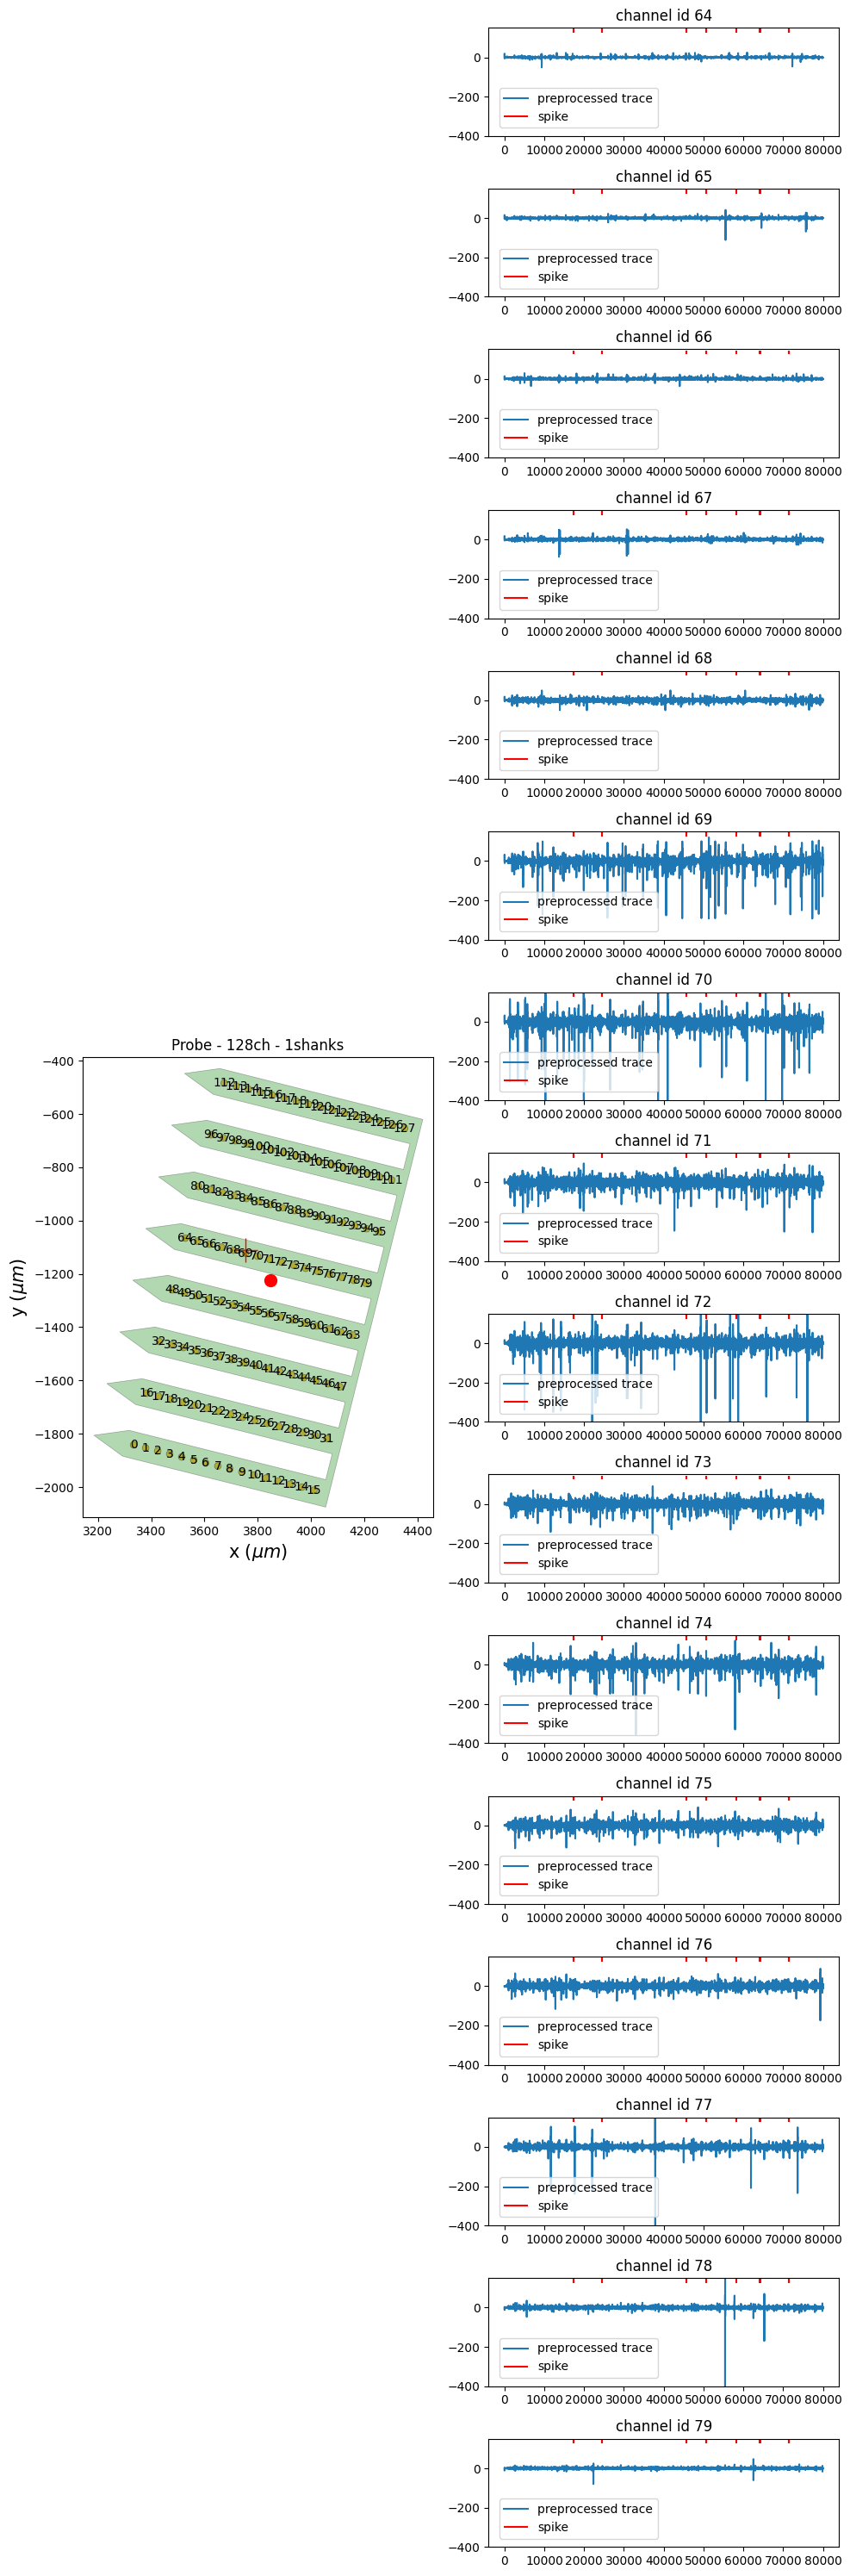

In [14]:
# plot
plot_unit_and_probe_location(
    cell_gid=most_active_pyr_gid, 
    circuit=simulation["circuit"], 
    raw_traces=simulated_traces, 
    preprocessed_traces=preprocessed_traces, 
    groundtruthspike=GroundTruthSpike, 
    waveform_path = config["dataset_conf"]["input"]["waveform_path"],
    n_sample=N_SAMPLE, 
    channel_id=CHANNEL_ID, 
    min_max_amplitude=MIN_MAX_AMPLITUDE
    )

## Validate cells' waveforms

### Compare two methods

#### Method 1

[TODO]:
- The waveforms seem incorrect
    - obs:
        - Action potentials should be centered but occur later
        - extracted waveforms from SpikeInterface are always 80 steps x-axis despite ms_before, why?
    - hypothesis: 
        - the spikes are associated with the wrong trace files
        - the cell location is wrong


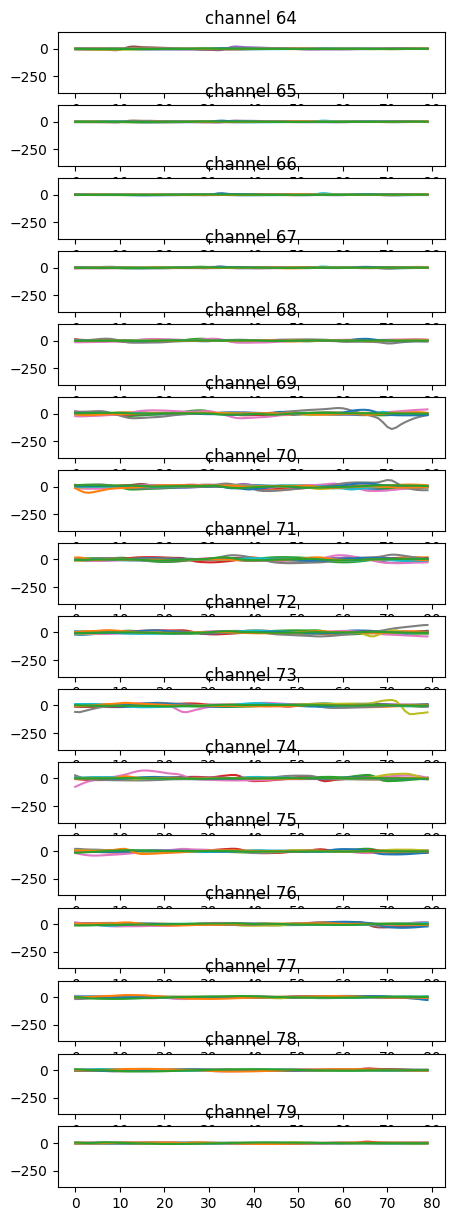

In [15]:
# plot directly with the Waveform extractor
fig = plot_unit_waveform_by_channel_with_SI(
    preprocessed_traces, 
    GroundTruthSpike, 
    config["dataset_conf"]["input"]["waveform_path"], 
    most_active_pyr_gid, 
    channel_id=CHANNEL_ID, 
    min_max_amplitude=MIN_MAX_AMPLITUDE, 
    ms_before=8, 
    ms_after=8
    )

cell (gid):  3942311
spike (count):  13
spikes (color)


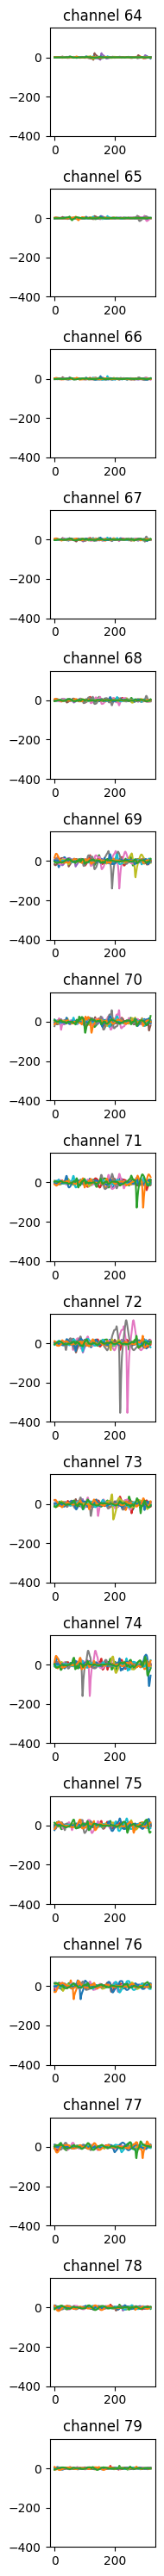

In [16]:
# get most active unit's spike train
most_active_pyr_spikes = GroundTruthSpike.get_unit_spike_train(unit_id = most_active_pyr_gid)
most_active_pyr_spikes = most_active_pyr_spikes[most_active_pyr_spikes<N_SAMPLE]

# report 
print("cell (gid): ", most_active_pyr_gid)
print("spike (count): ", len(most_active_pyr_spikes))
print("spikes (color)")

# replicate plot with custom code to validate
fig = plot_unit_waveform_by_channel_custom(
    cell_spike = most_active_pyr_spikes, preprocessed_traces=preprocessed_traces, channel_id=CHANNEL_ID, min_max_amplitude=MIN_MAX_AMPLITUDE, ms_before=8, ms_after=8
)

#### Method 2

In [17]:
# report object type
print(type(GroundTruthSpike))
print(type(preprocessed_traces))

<class 'spikeinterface.core.npzfolder.NpzFolderSorting'>
<class 'spikeinterface.preprocessing.common_reference.CommonReferenceRecording'>


write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


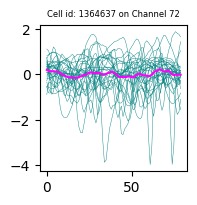

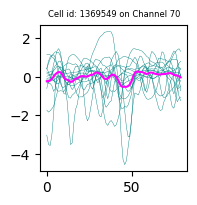

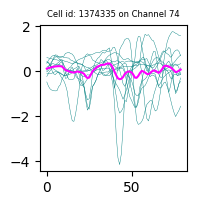

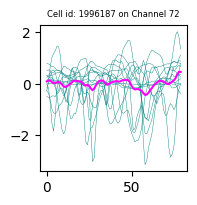

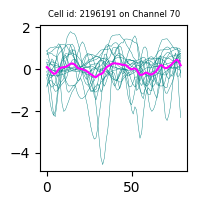

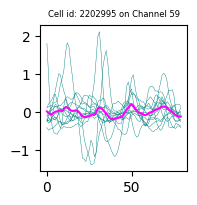

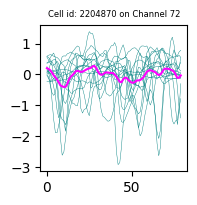

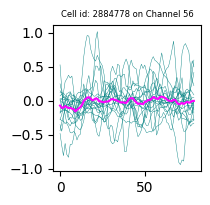

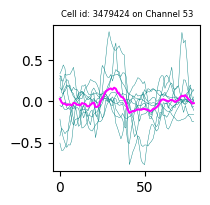

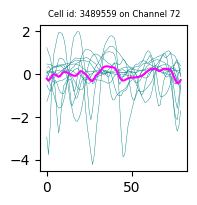

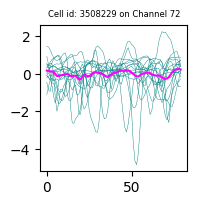

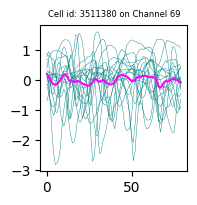

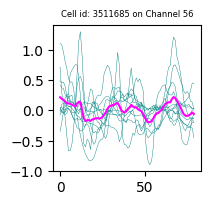

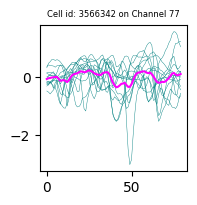

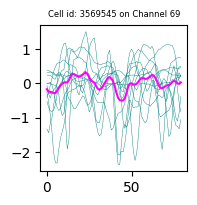

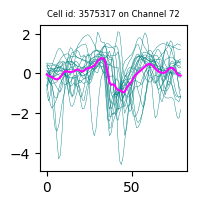

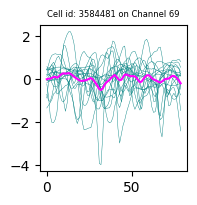

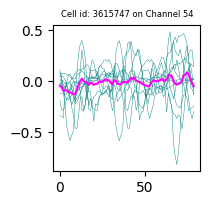

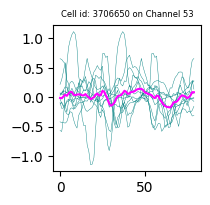

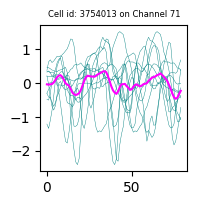

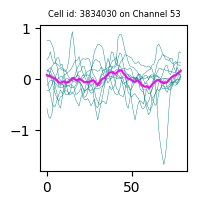

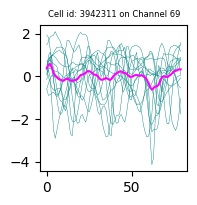

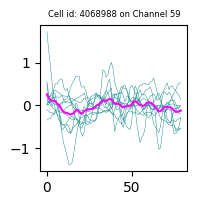

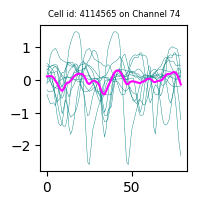

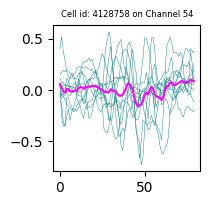

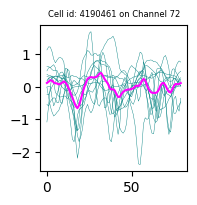

In [18]:
# select active cell
GroundTruthSpike = get_cell_spiking_above_thresh(GroundTruthSpike, min_spike=MIN_SPIKE)

# bundle spike and trace data for study
study_object = create_study_object(preprocessed_traces, GroundTruthSpike)

# extract waveforms
waveform_extractor = viz.get_waveform_extractor_and_ground_truth(study_object, study_folder=STUDY_FOLDER)

# plot
viz.plot_neuron_best_waveform(preprocessed_traces, GroundTruthSpike, waveform_extractor, study_folder=STUDY_FOLDER)

### Validate by cell type

We plotted waveforms for all active cells sorted by type

In [25]:
# report cell morphological types
cell_properties.morph_class.unique()

['PYR', 'INT']
Categories (2, object): ['INT', 'PYR']

9
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


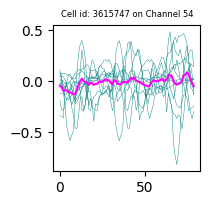

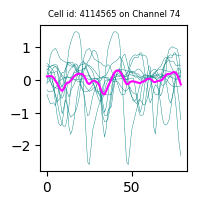

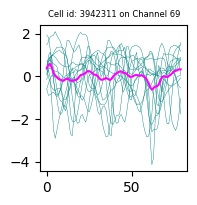

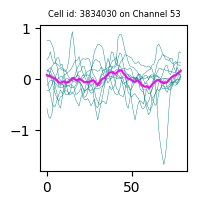

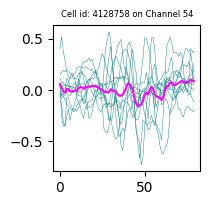

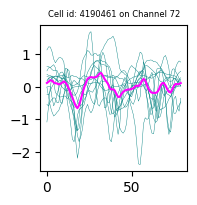

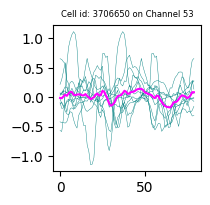

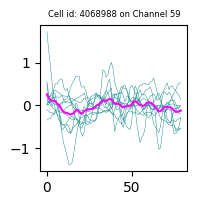

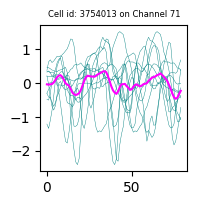

In [19]:
# get cell ids of interest
active_cell_ids = get_cell_id_spiking_above_thresh(GroundTruthSpike, min_spike=MIN_SPIKE)
active_pyramidal_gids = list(set(pyramidal_gids) & set(active_cell_ids))
plot_waveform_for(active_pyramidal_gids, GroundTruthSpike, preprocessed_traces)

17
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None


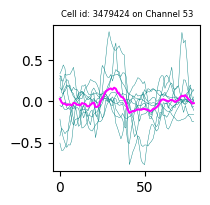

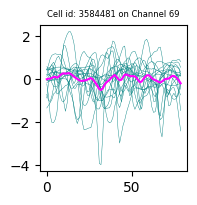

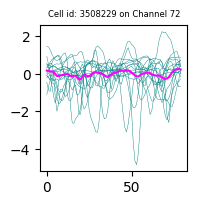

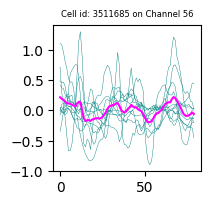

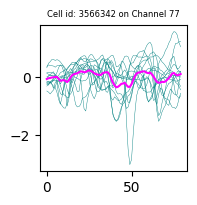

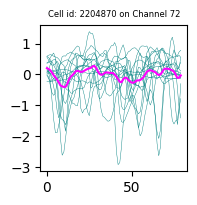

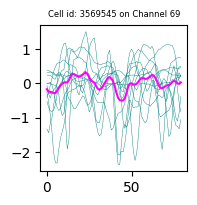

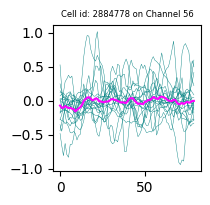

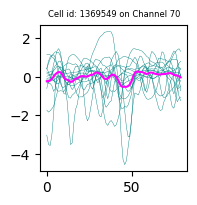

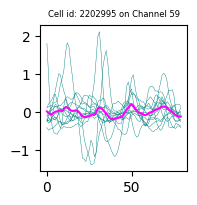

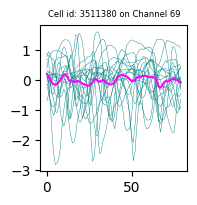

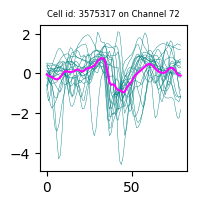

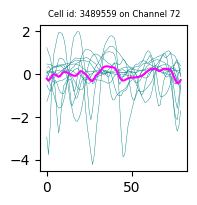

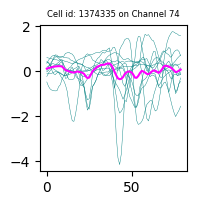

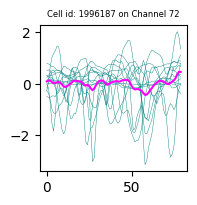

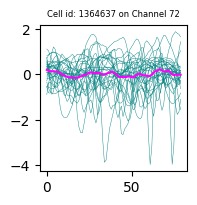

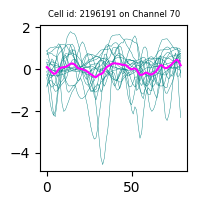

In [42]:
# plot active interneuron cells
interneurons_gids = cell_properties[cell_properties.morph_class=='INT'].index
active_interneuron_gids = list(set(interneurons_gids) & set(active_cell_ids))
plot_waveform_for(active_interneuron_gids, GroundTruthSpike, preprocessed_traces)